In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
import re
import math as m

## Basic Observations on Data

In [3]:
df=pd.read_csv('delhivery_data.csv')

In [5]:
dfs=df.copy()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144867 entries, 0 to 144866
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   data                            144867 non-null  object 
 1   trip_creation_time              144867 non-null  object 
 2   route_schedule_uuid             144867 non-null  object 
 3   route_type                      144867 non-null  object 
 4   trip_uuid                       144867 non-null  object 
 5   source_center                   144867 non-null  object 
 6   source_name                     144574 non-null  object 
 7   destination_center              144867 non-null  object 
 8   destination_name                144606 non-null  object 
 9   od_start_time                   144867 non-null  object 
 10  od_end_time                     144867 non-null  object 
 11  start_scan_to_end_scan          144867 non-null  float64
 12  is_cutoff       

In [7]:
df.isnull().sum()

,0
data,0
trip_creation_time,0
route_schedule_uuid,0
route_type,0
trip_uuid,0
source_center,0
source_name,293
destination_center,0
destination_name,261
od_start_time,0


In [8]:
dfs=df.copy()

In [9]:
df['source_name']=df['source_name'].fillna('Unknown source')
df['destination_name']=df['destination_name'].fillna('Unknown destination')

In [10]:
df.isnull().sum().sum()

0

In [111]:
dfs.shape

(144867, 40)

In [14]:
dfs.describe(include=object)

,data,trip_creation_time,route_schedule_uuid,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,od_start_time,od_end_time,cutoff_timestamp,src_city,dest_city,src_place,dest_place,src_code,dest_code,src_state,dest_state
count,144867,144867,144867,144867,144867,144867,144867,144867,144867,144867,144867,144867,144867,144867,144867,144867,144867,144867,144867,144867
unique,2,14817,1504,2,14817,1508,1499,1481,1469,26369,26369,93180,1263,1259,1179,1155,25,28,32,33
top,training,2018-09-28 05:23:15.359220,thanos::sroute:4029a8a2-6c74-4b7e-a6d8-f9e069f...,FTL,trip-153811219535896559,IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),2018-09-21 18:37:09.322207,2018-09-24 09:59:15.691618,2018-09-24 05:19:20,Gurgaon,Gurgaon,Bilaspur,Bilaspur,HB,H,Haryana,Karnataka
freq,104858,101,1812,99660,101,23347,23347,15192,15192,81,81,40,23665,15393,23464,15363,41177,34584,27336,20558


In [15]:
df['trip_creation_time']=pd.to_datetime(df['trip_creation_time'])
df['od_start_time']=pd.to_datetime(df['od_start_time'])
df['od_end_time']=pd.to_datetime(df['od_end_time'])
df['cutoff_timestamp']=pd.to_datetime(df['cutoff_timestamp'], format='mixed')

# Trip Segment Analysis

Delivery details of one package is divided into several rows (think of it as connecting flights to reach a particular destination) we should find way to identify unique trip details for source_destination to understand delivery data.


we can create unique identifier for different segment of a trip based on combination of trip_uuid, source_center and destination_center, we will call it as segment key

Based on segment_key we will create new aggregated columns segment_actual_time,segment_osrm_distance,segment_osrm_time

In [16]:
df['segment_key']=df.apply(lambda x:"#".join([x['trip_uuid'],x['source_center'],x['destination_center']]), axis=1)

In [17]:
df['segment_actual_time_cumsum']=df.groupby('segment_key')['segment_actual_time'].transform(lambda x:x.cumsum())

df['segment_osrm_time_cumsum']=df.groupby('segment_key')['segment_osrm_time'].transform(lambda x:x.cumsum())

df['segment_osrm_distance_cumsum']=df.groupby('segment_key')['segment_osrm_distance'].transform(lambda x:x.cumsum())

In [18]:
df['segment_actual_time_sum']=df.groupby('segment_key')['segment_actual_time_cumsum'].transform(lambda x:x.iloc[-1])
df['segment_osrm_time_sum']=df.groupby('segment_key')['segment_osrm_time_cumsum'].transform(lambda x:x.iloc[-1])
df['segment_osrm_distance_sum']=df.groupby('segment_key')['segment_osrm_distance_cumsum'].transform(lambda x:x.iloc[-1])

In [19]:
df=df.sort_values(by=['segment_key','od_end_time'])
df.sample(5)

,data,trip_creation_time,route_schedule_uuid,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,od_start_time,...,segment_osrm_time,segment_osrm_distance,segment_factor,segment_key,segment_actual_time_cumsum,segment_osrm_time_cumsum,segment_osrm_distance_cumsum,segment_actual_time_sum,segment_osrm_time_sum,segment_osrm_distance_sum
125002,training,2018-09-12 00:00:16.535741,thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...,FTL,trip-153671041653548748,IND209304AAA,Kanpur_Central_H_6 (Uttar Pradesh),IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),2018-09-12 16:39:46.858469,...,33.0,38.0620,1.515152,trip-153671041653548748#IND209304AAA#IND000000ACB,50.0,33.0,38.0620,728.0,534.0,670.6205
125003,training,2018-09-12 00:00:16.535741,thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...,FTL,trip-153671041653548748,IND209304AAA,Kanpur_Central_H_6 (Uttar Pradesh),IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),2018-09-12 16:39:46.858469,...,8.0,10.9921,1.125000,trip-153671041653548748#IND209304AAA#IND000000ACB,59.0,41.0,49.0541,728.0,534.0,670.6205
125004,training,2018-09-12 00:00:16.535741,thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...,FTL,trip-153671041653548748,IND209304AAA,Kanpur_Central_H_6 (Uttar Pradesh),IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),2018-09-12 16:39:46.858469,...,22.0,30.6308,1.545455,trip-153671041653548748#IND209304AAA#IND000000ACB,93.0,63.0,79.6849,728.0,534.0,670.6205
125005,training,2018-09-12 00:00:16.535741,thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...,FTL,trip-153671041653548748,IND209304AAA,Kanpur_Central_H_6 (Uttar Pradesh),IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),2018-09-12 16:39:46.858469,...,17.0,25.0959,1.470588,trip-153671041653548748#IND209304AAA#IND000000ACB,118.0,80.0,104.7808,728.0,534.0,670.6205
125006,training,2018-09-12 00:00:16.535741,thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...,FTL,trip-153671041653548748,IND209304AAA,Kanpur_Central_H_6 (Uttar Pradesh),IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),2018-09-12 16:39:46.858469,...,14.0,21.0389,1.428571,trip-153671041653548748#IND209304AAA#IND000000ACB,138.0,94.0,125.8197,728.0,534.0,670.6205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86464,test,2018-10-03 23:59:14.390954,thanos::sroute:c5f2ba2c-8486-4940-8af6-d1d2a6a...,Carting,trip-153861115439069069,IND628801AAA,Eral_Busstand_D (Tamil Nadu),IND628204AAA,Tirchchndr_Shnmgprm_D (Tamil Nadu),2018-10-04 01:44:53.808000,...,6.0,6.4998,1.333333,trip-153861115439069069#IND628801AAA#IND628204AAA,29.0,14.0,16.0184,29.0,14.0,16.0184
11572,test,2018-10-03 23:59:42.701692,thanos::sroute:412fea14-6d1f-4222-8a5f-a517042...,FTL,trip-153861118270144424,IND583119AAA,Sandur_WrdN1DPP_D (Karnataka),IND583101AAA,Bellary_Dc (Karnataka),2018-10-04 03:58:40.726547,...,17.0,23.9866,2.647059,trip-153861118270144424#IND583119AAA#IND583101AAA,45.0,17.0,23.9866,233.0,42.0,52.5303
11573,test,2018-10-03 23:59:42.701692,thanos::sroute:412fea14-6d1f-4222-8a5f-a517042...,FTL,trip-153861118270144424,IND583119AAA,Sandur_WrdN1DPP_D (Karnataka),IND583101AAA,Bellary_Dc (Karnataka),2018-10-04 03:58:40.726547,...,25.0,28.5437,7.520000,trip-153861118270144424#IND583119AAA#IND583101AAA,233.0,42.0,52.5303,233.0,42.0,52.5303
11570,test,2018-10-03 23:59:42.701692,thanos::sroute:412fea14-6d1f-4222-8a5f-a517042...,FTL,trip-153861118270144424,IND583201AAA,Hospet (Karnataka),IND583119AAA,Sandur_WrdN1DPP_D (Karnataka),2018-10-04 02:51:44.712656,...,21.0,23.2367,1.428571,trip-153861118270144424#IND583201AAA#IND583119AAA,30.0,21.0,23.2367,41.0,25.0,28.0484


## . Feature Engineering

In [20]:
df['od_time_diff_hour']=(df['od_end_time']-df['od_start_time'])/pd.Timedelta(hours=1)

In [21]:
df['trip_creation_year']=df['trip_creation_time'].dt.year
df['trip_creation_month']=df['trip_creation_time'].dt.month
df['trip_creation_day']=df['trip_creation_time'].dt.day

In [56]:

df['source_name'] = df['source_name'].astype(str)
df['destination_name'] = df['destination_name'].astype(str)


df['source_city'] = df['source_name'].apply(
    lambda x: x.split('_')[0] if isinstance(x, str) and '_' in x else 'Unknown'
)

df['destination_city'] = df['destination_name'].apply(
    lambda x: x.split('_')[0] if isinstance(x, str) and '_' in x else 'Unknown'
)

df['source_place'] = df['source_name'].apply(
    lambda x: x.split('_')[1] if isinstance(x, str) and len(x.split('_')) > 1 else 'Unknown'
)

df['destination_place'] = df['destination_name'].apply(
    lambda x: x.split('_')[1] if isinstance(x, str) and len(x.split('_')) > 1 else 'Unknown'
)

df['source_code'] = df['source_name'].apply(
    lambda x: x.split('_')[2].split('(')[0] if isinstance(x, str) and len(x.split('_')) > 2 else 'Unknown'
)

df['destination_code'] = df['destination_name'].apply(
    lambda x: x.split('_')[2].split('(')[0] if isinstance(x, str) and len(x.split('_')) > 2 else 'Unknown'
)

df['source_state'] = df['source_name'].apply(
    lambda x: x.split('(')[1][:-1] if isinstance(x, str) and '(' in x else 'Unknown'
)

df['destination_state'] = df['destination_name'].apply(
    lambda x: x.split('(')[1][:-1] if isinstance(x, str) and '(' in x else 'Unknown'
)


In [57]:
df.sample(5)

,data,trip_creation_time,route_schedule_uuid,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,od_start_time,...,trip_creation_month,trip_creation_day,source_city,destination_city,source_place,destination_place,source_code,destination_code,source_state,destination_state
52629,training,2018-09-21 13:46:45.851448,thanos::sroute:fccc9d7d-a31b-45e5-a1cf-eaa191e...,FTL,trip-153753760585119186,IND577201AAA,Shimoga_DC (Karnataka),IND562132AAA,Bangalore_Nelmngla_H (Karnataka),2018-09-22 04:55:04.343011,...,9,21,Shimoga,Bangalore,DC (Karnataka),Nelmngla,Unknown,H,Karnataka,Karnataka
51476,test,2018-09-27 14:41:36.457278,thanos::sroute:3592c86e-c3d1-429b-917a-ebe9051...,FTL,trip-153805929645698249,IND712311AAA,Kolkata_Dankuni_HB (West Bengal),IND421302AAG,Bhiwandi_Mankoli_HB (Maharashtra),2018-09-29 18:54:31.061435,...,9,27,Kolkata,Bhiwandi,Dankuni,Mankoli,HB,HB,West Bengal,Maharashtra
133141,training,2018-09-18 22:25:17.066461,thanos::sroute:c57f3600-80a6-44b6-835e-aad83da...,Carting,trip-153730951706622074,IND382421AAA,Gandhinagar_DC (Gujarat),IND382721AAA,Gandhinagar_Kalol_DC (Gujarat),2018-09-19 01:08:59.940372,...,9,18,Gandhinagar,Gandhinagar,DC (Gujarat),Kalol,Unknown,DC,Gujarat,Gujarat
4159,test,2018-09-28 04:51:24.498248,thanos::sroute:25dd334d-e30d-4cfa-b6e8-192bcfe...,FTL,trip-153811028449800691,IND751002AAB,Bhubaneshwar_Hub (Orissa),IND562132AAA,Bangalore_Nelmngla_H (Karnataka),2018-09-28 18:06:24.280790,...,9,28,Bhubaneshwar,Bangalore,Hub (Orissa),Nelmngla,Unknown,H,Orissa,Karnataka
124462,training,2018-09-23 02:44:13.665024,thanos::sroute:f01c8bbd-655d-42ea-9abf-60d5040...,FTL,trip-153767065366477819,IND821115AAB,Sasaram_Central_I_2 (Bihar),IND209304AAA,Kanpur_Central_H_6 (Uttar Pradesh),2018-09-23 17:32:37.941229,...,9,23,Sasaram,Kanpur,Central,Central,I,H,Bihar,Uttar Pradesh


## In-depth analysis: Grouping and Aggregating at Trip-level

In [58]:
trip_actual_time_sum_df=df.groupby(['trip_uuid','segment_key']).nth(-1).groupby(['trip_uuid']).agg(trip_actual_time_sum=('actual_time','sum')).reset_index()
trip_actual_time_sum_df

,trip_uuid,trip_actual_time_sum
0,trip-153671041653548748,1562.0
1,trip-153671042288605164,143.0
2,trip-153671043369099517,3347.0
3,trip-153671046011330457,59.0
4,trip-153671052974046625,341.0
...,...,...
14812,trip-153861095625827784,83.0
14813,trip-153861104386292051,21.0
14814,trip-153861106442901555,282.0
14815,trip-153861115439069069,264.0


In [59]:
trip_segment_actual_time_sum_df=df.groupby(['trip_uuid','segment_key']).nth(-1).groupby(['trip_uuid']).agg(trip_segment_actual_time_sum=('segment_actual_time_sum','sum')).reset_index()
trip_segment_actual_time_sum_df

,trip_uuid,trip_segment_actual_time_sum
0,trip-153671041653548748,1548.0
1,trip-153671042288605164,141.0
2,trip-153671043369099517,3308.0
3,trip-153671046011330457,59.0
4,trip-153671052974046625,340.0
...,...,...
14812,trip-153861095625827784,82.0
14813,trip-153861104386292051,21.0
14814,trip-153861106442901555,281.0
14815,trip-153861115439069069,258.0


In [60]:
trip_segment_osrm_time_sum_df=df.groupby(['trip_uuid','segment_key']).nth(-1).groupby(['trip_uuid']).agg(trip_segment_osrm_time_sum=('segment_osrm_time_sum','sum')).reset_index()
trip_segment_osrm_time_sum_df

,trip_uuid,trip_segment_osrm_time_sum
0,trip-153671041653548748,1008.0
1,trip-153671042288605164,65.0
2,trip-153671043369099517,1941.0
3,trip-153671046011330457,16.0
4,trip-153671052974046625,115.0
...,...,...
14812,trip-153861095625827784,62.0
14813,trip-153861104386292051,11.0
14814,trip-153861106442901555,88.0
14815,trip-153861115439069069,221.0


In [61]:
trip_segment_osrm_distance_sum_df=df.groupby(['trip_uuid','segment_key']).nth(-1).groupby(['trip_uuid']).agg(trip_segment_osrm_distance_sum=('segment_osrm_distance_sum','sum')).reset_index()
trip_segment_osrm_distance_sum_df

,trip_uuid,trip_segment_osrm_distance_sum
0,trip-153671041653548748,1320.4733
1,trip-153671042288605164,84.1894
2,trip-153671043369099517,2545.2678
3,trip-153671046011330457,19.8766
4,trip-153671052974046625,146.7919
...,...,...
14812,trip-153861095625827784,64.8551
14813,trip-153861104386292051,16.0883
14814,trip-153861106442901555,104.8866
14815,trip-153861115439069069,223.5324


In [62]:
trip_osrm_time_sum_df=df.groupby(['trip_uuid','segment_key']).nth(-1).groupby(['trip_uuid']).agg(trip_osrm_time_sum=('osrm_time','sum')).reset_index()
trip_osrm_time_sum_df

,trip_uuid,trip_osrm_time_sum
0,trip-153671041653548748,717.0
1,trip-153671042288605164,68.0
2,trip-153671043369099517,1740.0
3,trip-153671046011330457,15.0
4,trip-153671052974046625,117.0
...,...,...
14812,trip-153861095625827784,62.0
14813,trip-153861104386292051,12.0
14814,trip-153861106442901555,48.0
14815,trip-153861115439069069,179.0


In [63]:
trip_osrm_distance_sum_df=df.groupby(['trip_uuid','segment_key']).nth(-1).groupby(['trip_uuid']).agg(trip_osrm_distance_sum=('osrm_distance','sum')).reset_index()
trip_osrm_distance_sum_df

,trip_uuid,trip_osrm_distance_sum
0,trip-153671041653548748,991.3523
1,trip-153671042288605164,85.1110
2,trip-153671043369099517,2354.0665
3,trip-153671046011330457,19.6800
4,trip-153671052974046625,146.7918
...,...,...
14812,trip-153861095625827784,73.4630
14813,trip-153861104386292051,16.0882
14814,trip-153861106442901555,58.9037
14815,trip-153861115439069069,171.1103


In [64]:
trip_total_time_in_hrs_df=df.groupby(['trip_uuid','segment_key']).nth(-1).groupby(['trip_uuid']).agg(trip_total_time_in_hrs=('od_time_diff_hour','sum')).reset_index()
trip_total_time_in_hrs_df

,trip_uuid,trip_total_time_in_hrs
0,trip-153671041653548748,37.668497
1,trip-153671042288605164,3.026865
2,trip-153671043369099517,65.572709
3,trip-153671046011330457,1.674916
4,trip-153671052974046625,11.972484
...,...,...
14812,trip-153861095625827784,4.300482
14813,trip-153861104386292051,1.009842
14814,trip-153861106442901555,7.035331
14815,trip-153861115439069069,5.808548


In [65]:
trip_aggregated_df=pd.concat(
    objs=(
            iDF.set_index('trip_uuid') for iDF in (trip_actual_time_sum_df,trip_osrm_time_sum_df, trip_osrm_distance_sum_df,
                                                 trip_segment_actual_time_sum_df,trip_segment_osrm_time_sum_df,trip_segment_osrm_distance_sum_df,
                                                 trip_total_time_in_hrs_df)
         ),
    axis=1,
    join='inner'
).reset_index()
trip_aggregated_df

,trip_uuid,trip_actual_time_sum,trip_osrm_time_sum,trip_osrm_distance_sum,trip_segment_actual_time_sum,trip_segment_osrm_time_sum,trip_segment_osrm_distance_sum,trip_total_time_in_hrs
0,trip-153671041653548748,1562.0,717.0,991.3523,1548.0,1008.0,1320.4733,37.668497
1,trip-153671042288605164,143.0,68.0,85.1110,141.0,65.0,84.1894,3.026865
2,trip-153671043369099517,3347.0,1740.0,2354.0665,3308.0,1941.0,2545.2678,65.572709
3,trip-153671046011330457,59.0,15.0,19.6800,59.0,16.0,19.8766,1.674916
4,trip-153671052974046625,341.0,117.0,146.7918,340.0,115.0,146.7919,11.972484
...,...,...,...,...,...,...,...,...
14812,trip-153861095625827784,83.0,62.0,73.4630,82.0,62.0,64.8551,4.300482
14813,trip-153861104386292051,21.0,12.0,16.0882,21.0,11.0,16.0883,1.009842
14814,trip-153861106442901555,282.0,48.0,58.9037,281.0,88.0,104.8866,7.035331
14815,trip-153861115439069069,264.0,179.0,171.1103,258.0,221.0,223.5324,5.808548


In [66]:
df=pd.merge(df,trip_aggregated_df, on='trip_uuid' )
df

,data,trip_creation_time,route_schedule_uuid,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,od_start_time,...,destination_code,source_state,destination_state,trip_actual_time_sum,trip_osrm_time_sum,trip_osrm_distance_sum,trip_segment_actual_time_sum,trip_segment_osrm_time_sum,trip_segment_osrm_distance_sum,trip_total_time_in_hrs
0,training,2018-09-12 00:00:16.535741,thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...,FTL,trip-153671041653548748,IND209304AAA,Kanpur_Central_H_6 (Uttar Pradesh),IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),2018-09-12 16:39:46.858469,...,HB,Uttar Pradesh,Haryana,1562.0,717.0,991.3523,1548.0,1008.0,1320.4733,37.668497
1,training,2018-09-12 00:00:16.535741,thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...,FTL,trip-153671041653548748,IND209304AAA,Kanpur_Central_H_6 (Uttar Pradesh),IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),2018-09-12 16:39:46.858469,...,HB,Uttar Pradesh,Haryana,1562.0,717.0,991.3523,1548.0,1008.0,1320.4733,37.668497
2,training,2018-09-12 00:00:16.535741,thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...,FTL,trip-153671041653548748,IND209304AAA,Kanpur_Central_H_6 (Uttar Pradesh),IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),2018-09-12 16:39:46.858469,...,HB,Uttar Pradesh,Haryana,1562.0,717.0,991.3523,1548.0,1008.0,1320.4733,37.668497
3,training,2018-09-12 00:00:16.535741,thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...,FTL,trip-153671041653548748,IND209304AAA,Kanpur_Central_H_6 (Uttar Pradesh),IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),2018-09-12 16:39:46.858469,...,HB,Uttar Pradesh,Haryana,1562.0,717.0,991.3523,1548.0,1008.0,1320.4733,37.668497
4,training,2018-09-12 00:00:16.535741,thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...,FTL,trip-153671041653548748,IND209304AAA,Kanpur_Central_H_6 (Uttar Pradesh),IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),2018-09-12 16:39:46.858469,...,HB,Uttar Pradesh,Haryana,1562.0,717.0,991.3523,1548.0,1008.0,1320.4733,37.668497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144862,test,2018-10-03 23:59:14.390954,thanos::sroute:c5f2ba2c-8486-4940-8af6-d1d2a6a...,Carting,trip-153861115439069069,IND628801AAA,Eral_Busstand_D (Tamil Nadu),IND628204AAA,Tirchchndr_Shnmgprm_D (Tamil Nadu),2018-10-04 01:44:53.808000,...,D,Tamil Nadu,Tamil Nadu,264.0,179.0,171.1103,258.0,221.0,223.5324,5.808548
144863,test,2018-10-03 23:59:42.701692,thanos::sroute:412fea14-6d1f-4222-8a5f-a517042...,FTL,trip-153861118270144424,IND583119AAA,Sandur_WrdN1DPP_D (Karnataka),IND583101AAA,Bellary_Dc (Karnataka),2018-10-04 03:58:40.726547,...,Unknown,Karnataka,Karnataka,275.0,68.0,80.5787,274.0,67.0,80.5787,5.906793
144864,test,2018-10-03 23:59:42.701692,thanos::sroute:412fea14-6d1f-4222-8a5f-a517042...,FTL,trip-153861118270144424,IND583119AAA,Sandur_WrdN1DPP_D (Karnataka),IND583101AAA,Bellary_Dc (Karnataka),2018-10-04 03:58:40.726547,...,Unknown,Karnataka,Karnataka,275.0,68.0,80.5787,274.0,67.0,80.5787,5.906793
144865,test,2018-10-03 23:59:42.701692,thanos::sroute:412fea14-6d1f-4222-8a5f-a517042...,FTL,trip-153861118270144424,IND583201AAA,Hospet (Karnataka),IND583119AAA,Sandur_WrdN1DPP_D (Karnataka),2018-10-04 02:51:44.712656,...,D,Karnataka,Karnataka,275.0,68.0,80.5787,274.0,67.0,80.5787,5.906793


## Outlier Detection & Treatment

In [67]:
trip_aggregated_df

,trip_uuid,trip_actual_time_sum,trip_osrm_time_sum,trip_osrm_distance_sum,trip_segment_actual_time_sum,trip_segment_osrm_time_sum,trip_segment_osrm_distance_sum,trip_total_time_in_hrs
0,trip-153671041653548748,1562.0,717.0,991.3523,1548.0,1008.0,1320.4733,37.668497
1,trip-153671042288605164,143.0,68.0,85.1110,141.0,65.0,84.1894,3.026865
2,trip-153671043369099517,3347.0,1740.0,2354.0665,3308.0,1941.0,2545.2678,65.572709
3,trip-153671046011330457,59.0,15.0,19.6800,59.0,16.0,19.8766,1.674916
4,trip-153671052974046625,341.0,117.0,146.7918,340.0,115.0,146.7919,11.972484
...,...,...,...,...,...,...,...,...
14812,trip-153861095625827784,83.0,62.0,73.4630,82.0,62.0,64.8551,4.300482
14813,trip-153861104386292051,21.0,12.0,16.0882,21.0,11.0,16.0883,1.009842
14814,trip-153861106442901555,282.0,48.0,58.9037,281.0,88.0,104.8866,7.035331
14815,trip-153861115439069069,264.0,179.0,171.1103,258.0,221.0,223.5324,5.808548


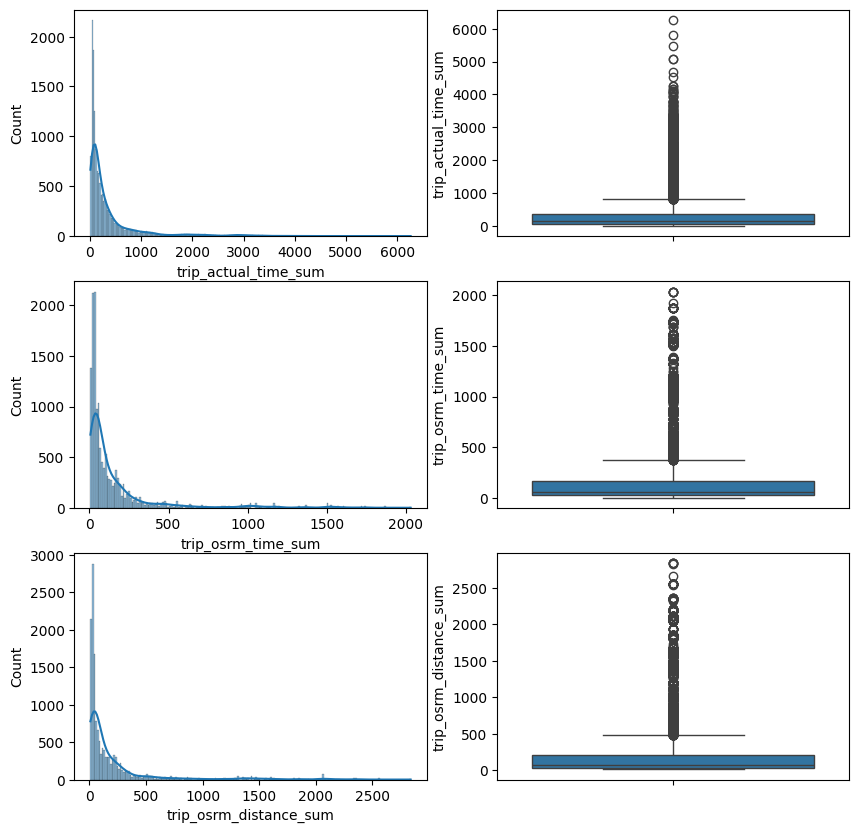

In [68]:
import warnings
warnings.filterwarnings("ignore")
fig, axs = plt.subplots(3, 2,  figsize=(10,10))
sns.histplot(ax=axs[0,0],data= trip_aggregated_df['trip_actual_time_sum'],kde=True)
sns.boxplot(ax=axs[0,1],data=trip_aggregated_df['trip_actual_time_sum'])

sns.histplot(ax=axs[1,0],data= trip_aggregated_df['trip_osrm_time_sum'],kde=True)
sns.boxplot(ax=axs[1,1],data= trip_aggregated_df['trip_osrm_time_sum'])

sns.histplot(ax=axs[2,0],data= trip_aggregated_df['trip_osrm_distance_sum'],kde=True)
sns.boxplot(ax=axs[2,1],data= trip_aggregated_df['trip_osrm_distance_sum'])


plt.show()

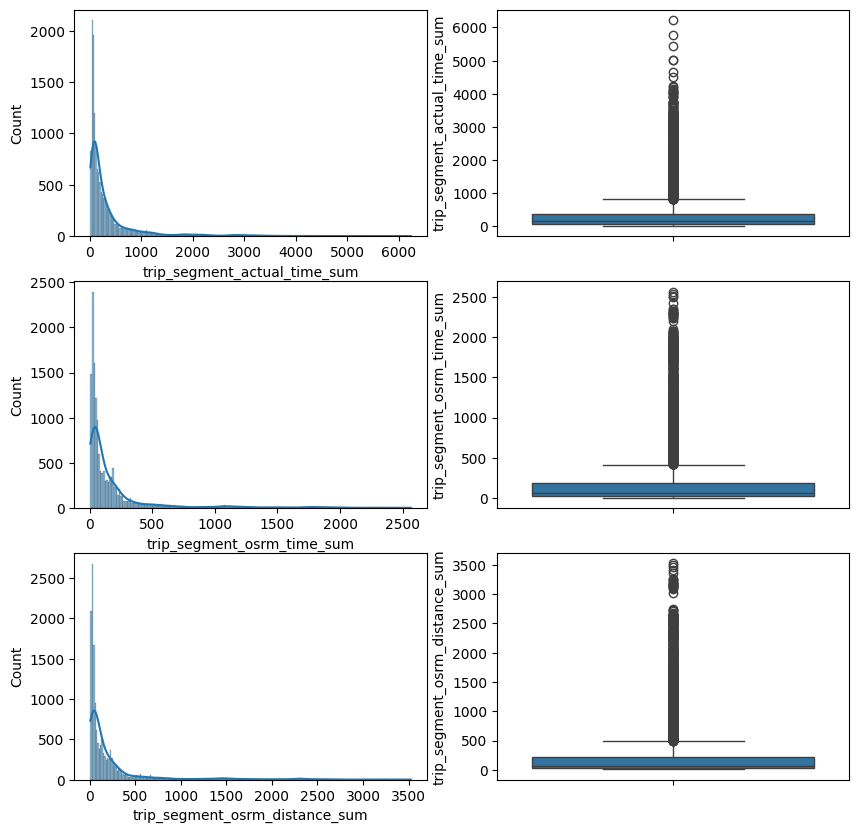

In [69]:
import warnings
warnings.filterwarnings("ignore")
fig, axs = plt.subplots(3, 2,  figsize=(10,10))

sns.histplot(ax=axs[0,0],data= trip_aggregated_df['trip_segment_actual_time_sum'],kde=True)
sns.boxplot(ax=axs[0,1],data= trip_aggregated_df['trip_segment_actual_time_sum'])


sns.histplot(ax=axs[1,0],data= trip_aggregated_df['trip_segment_osrm_time_sum'],kde=True)
sns.boxplot(ax=axs[1,1],data= trip_aggregated_df['trip_segment_osrm_time_sum'])

sns.histplot(ax=axs[2,0],data= trip_aggregated_df['trip_segment_osrm_distance_sum'],kde=True)
sns.boxplot(ax=axs[2,1],data= trip_aggregated_df['trip_segment_osrm_distance_sum'])

plt.show()

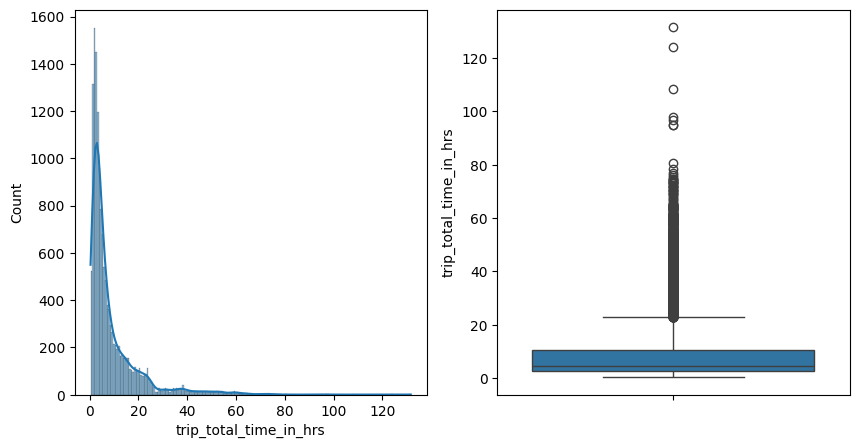

In [70]:
import warnings
warnings.filterwarnings("ignore")
fig, axs = plt.subplots(ncols= 2,  figsize=(10,5))
sns.histplot(ax=axs[0],data= trip_aggregated_df['trip_total_time_in_hrs'],kde=True)
sns.boxplot(ax=axs[1],data= trip_aggregated_df['trip_total_time_in_hrs'])
plt.show()

<Axes: xlabel='trip_actual_time_sum', ylabel='Count'>

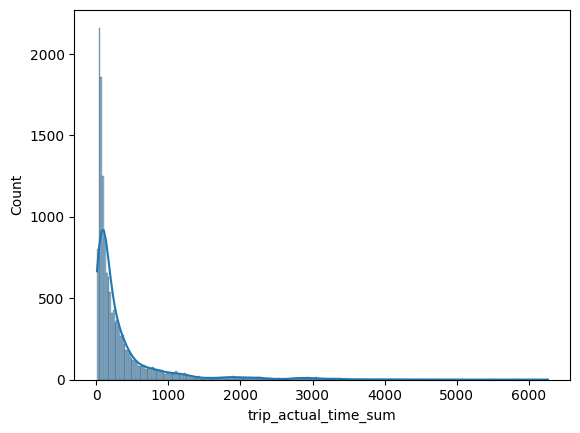

In [71]:
sns.histplot(data=trip_aggregated_df['trip_actual_time_sum'],kde=True)

<Axes: ylabel='trip_actual_time_sum'>

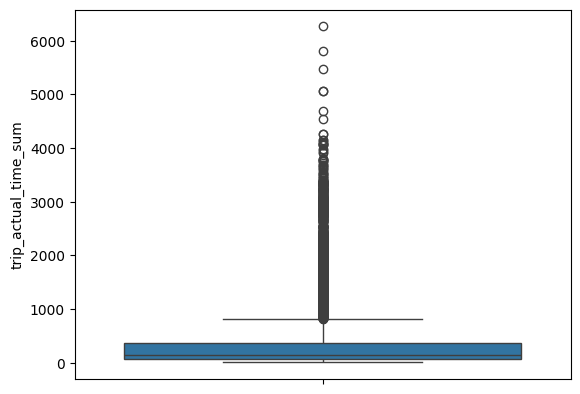

In [72]:
sns.boxplot(data=trip_aggregated_df['trip_actual_time_sum'])

# Observations
we have lots of outliers let's remove those outliers Based on IQR range, we will maxout values based on IQR range

In [73]:
def clip_value_helper(row,cl, Q1,Q3, minval, maxval):
    #     Q1=row[cl].quantile(0.25)
    #     Q3=row[cl].quantile(0.75)
    #     minval=min(row[cl])
    #     maxval=max(row[cl])
    IQR=Q3-Q1
    if row[cl]<Q1-1.5*IQR:
        return min(minval, Q1-1.5*IQR)
    elif row[cl] > Q3+1.5*IQR:
        return min(maxval, Q3+1.5*IQR)
    else:
        return row[cl]

In [74]:
trip_aggregated_df.columns

Index(['trip_uuid', 'trip_actual_time_sum', 'trip_osrm_time_sum',
       'trip_osrm_distance_sum', 'trip_segment_actual_time_sum',
       'trip_segment_osrm_time_sum', 'trip_segment_osrm_distance_sum',
       'trip_total_time_in_hrs'],
      dtype='object')

In [75]:
for cl in ['trip_actual_time_sum', 'trip_osrm_time_sum', 'trip_osrm_distance_sum', 'trip_segment_actual_time_sum','trip_segment_osrm_time_sum', 'trip_segment_osrm_distance_sum','trip_total_time_in_hrs']:
    Q1=trip_aggregated_df[cl].quantile(0.25)
    Q3=trip_aggregated_df[cl].quantile(0.75)
    minval=min(trip_aggregated_df[cl])
    maxval=max(trip_aggregated_df[cl])
    trip_aggregated_df[cl]=trip_aggregated_df.apply(lambda row:clip_value_helper(row,cl,
                                                                     Q1,Q3,minval, maxval) , axis=1)

In [76]:
trip_aggregated_df

,trip_uuid,trip_actual_time_sum,trip_osrm_time_sum,trip_osrm_distance_sum,trip_segment_actual_time_sum,trip_segment_osrm_time_sum,trip_segment_osrm_distance_sum,trip_total_time_in_hrs
0,trip-153671041653548748,824.5,376.5,474.9587,818.5,416.0,498.02425,22.843363
1,trip-153671042288605164,143.0,68.0,85.1110,141.0,65.0,84.18940,3.026865
2,trip-153671043369099517,824.5,376.5,474.9587,818.5,416.0,498.02425,22.843363
3,trip-153671046011330457,59.0,15.0,19.6800,59.0,16.0,19.87660,1.674916
4,trip-153671052974046625,341.0,117.0,146.7918,340.0,115.0,146.79190,11.972484
...,...,...,...,...,...,...,...,...
14812,trip-153861095625827784,83.0,62.0,73.4630,82.0,62.0,64.85510,4.300482
14813,trip-153861104386292051,21.0,12.0,16.0882,21.0,11.0,16.08830,1.009842
14814,trip-153861106442901555,282.0,48.0,58.9037,281.0,88.0,104.88660,7.035331
14815,trip-153861115439069069,264.0,179.0,171.1103,258.0,221.0,223.53240,5.808548


By Clipping Outliers Based On IQR Distribution

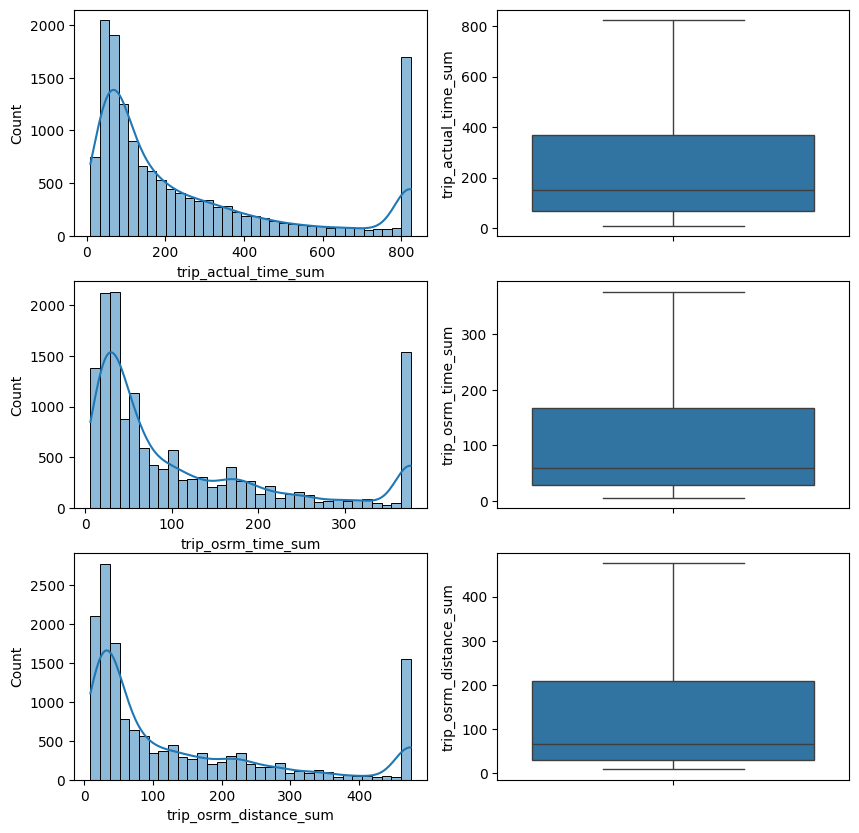

In [77]:
import warnings
warnings.filterwarnings("ignore")
fig, axs = plt.subplots(3, 2,  figsize=(10,10))
sns.histplot(ax=axs[0,0],data= trip_aggregated_df['trip_actual_time_sum'],kde=True)
sns.boxplot(ax=axs[0,1],data=trip_aggregated_df['trip_actual_time_sum'])

sns.histplot(ax=axs[1,0],data= trip_aggregated_df['trip_osrm_time_sum'],kde=True)
sns.boxplot(ax=axs[1,1],data= trip_aggregated_df['trip_osrm_time_sum'])

sns.histplot(ax=axs[2,0],data= trip_aggregated_df['trip_osrm_distance_sum'],kde=True)
sns.boxplot(ax=axs[2,1],data= trip_aggregated_df['trip_osrm_distance_sum'])


plt.show()

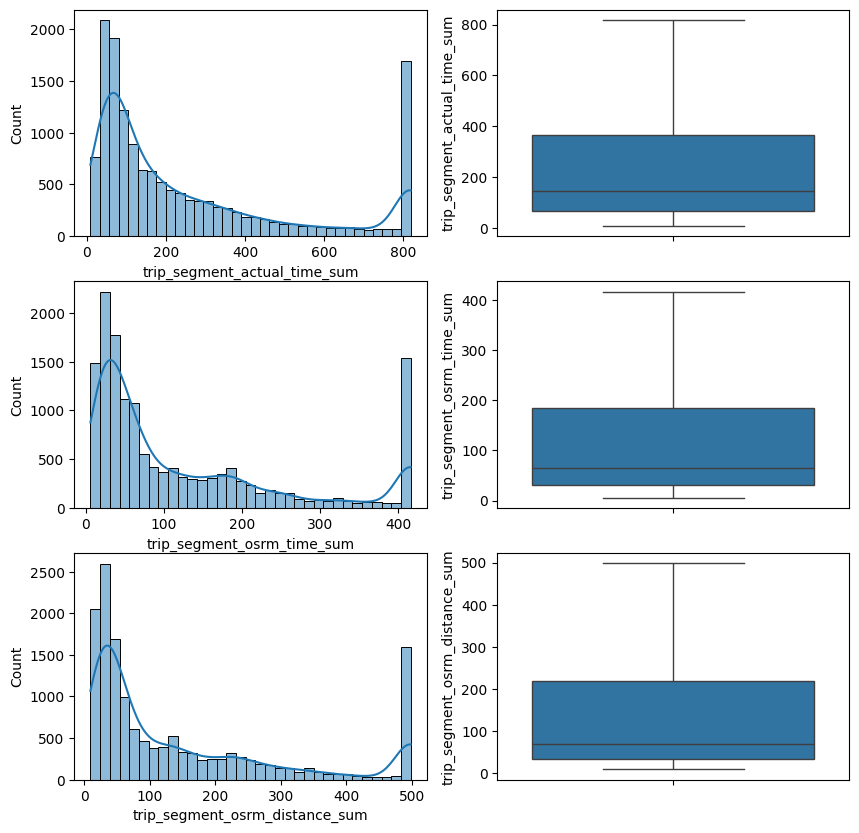

In [79]:
import warnings
warnings.filterwarnings("ignore")
fig, axs = plt.subplots(3, 2,  figsize=(10,10))

sns.histplot(ax=axs[0,0],data= trip_aggregated_df['trip_segment_actual_time_sum'],kde=True)
sns.boxplot(ax=axs[0,1],data= trip_aggregated_df['trip_segment_actual_time_sum'])


sns.histplot(ax=axs[1,0],data= trip_aggregated_df['trip_segment_osrm_time_sum'],kde=True)
sns.boxplot(ax=axs[1,1],data= trip_aggregated_df['trip_segment_osrm_time_sum'])

sns.histplot(ax=axs[2,0],data= trip_aggregated_df['trip_segment_osrm_distance_sum'],kde=True)
sns.boxplot(ax=axs[2,1],data= trip_aggregated_df['trip_segment_osrm_distance_sum'])

plt.show()

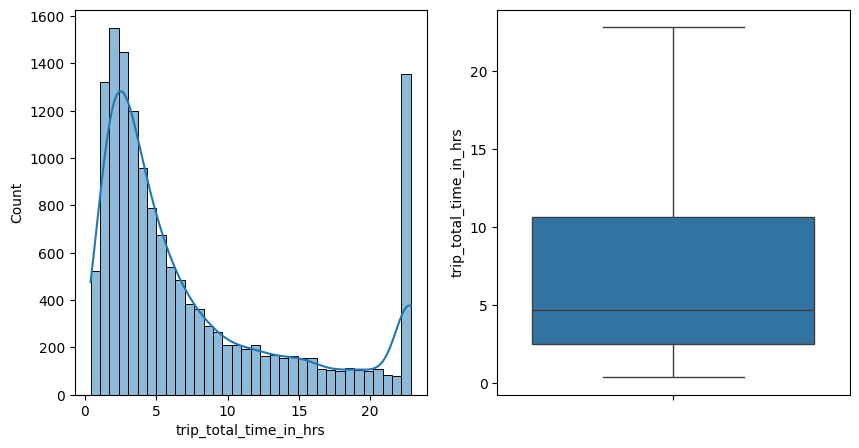

In [80]:
import warnings
warnings.filterwarnings("ignore")
fig, axs = plt.subplots(ncols= 2,  figsize=(10,5))
sns.histplot(ax=axs[0],data= trip_aggregated_df['trip_total_time_in_hrs'],kde=True)
sns.boxplot(ax=axs[1],data= trip_aggregated_df['trip_total_time_in_hrs'])
plt.show()

## Hypothesis Testing

actual_time aggregated value and OSRM time aggregated value.


we can use t-test paired sample test to know if there is significant difference in actual trip aggregated time and OSRM trip aggregated time for each trip

HO : Mean Actual time to deliver package from source to destination is lesser than OSRM time for entire trip

HA: Mean Actual time to deliver package from source to destination is greater than OSRM time

In [81]:
from scipy.stats import ttest_rel, ttest_ind

In [82]:
stat, pval=ttest_rel(trip_aggregated_df['trip_actual_time_sum'],
                     trip_aggregated_df['trip_osrm_time_sum'],
                    alternative='greater')
print(f"stat {stat} pval {pval}")

stat 112.65800437716281 pval 0.0


In [83]:
if pval <0.05:
    print("We will reject H0 :")
    print("mean Actual time to deliver package from source to destination is greater than OSRM time")
else:
    print("We fail to  reject H0 :")
    print("mean Actual time to deliver package from source to destination is lesser or equal  than OSRM time")

We will reject H0 :
mean Actual time to deliver package from source to destination is greater than OSRM time


In [84]:
np.mean(trip_aggregated_df['trip_actual_time_sum']), np.mean(trip_aggregated_df['trip_osrm_time_sum'])

(263.8497334143214, 114.87537963150436)

actual_time aggregated value and segment actual time aggregated value.

we can use t=test paired sample test to know if there is significant difference in actual trip aggregated time and segment actual time aggregated value for each trip

HO : Mean Actual aggregated trip time to deliver package from source to destination is lesser than segment actual time aggregated value  for entire trip

HA: Mean Actual aggregated trip time to deliver package from source to destination is greater than segment actual time aggregated value  for entire trip

In [85]:
stat, pval=ttest_rel(trip_aggregated_df['trip_actual_time_sum'],
                     trip_aggregated_df['trip_segment_actual_time_sum'],
                    alternative='greater')
print(f"stat {stat} pval {pval}")

stat 122.32203996614452 pval 0.0


In [86]:
if pval <0.05:
    print("We will reject H0 :")
    print("mean Actual trip aggregated time   to deliver package from source to destination is greater than segment actual aggregated time")
else:
    print("We fail to  reject H0 :")
    print("mean Actual trip aggregated time to deliver package from source to destination is lesser or equal  than segment actual aggregated time")

We will reject H0 :
mean Actual trip aggregated time   to deliver package from source to destination is greater than segment actual aggregated time


OSRM distance aggregated value and segment OSRM distance aggregated value.

we can use ttest paired sample test to know if there is significant difference in OSRM distance aggregated value and segment actual aggregated distance for each trip

HO : Mean Actual aggregated OSRM distance for trip to deliver package from source to destination is lesser than segment actual OSRM distance  aggregated value  for entire trip

HA: Mean Actual aggregated OSRM distance  for trip to deliver package from source to destination is greater than segment actual OSRM distance  aggregated value  for entire trip

In [87]:
stat, pval=ttest_rel(trip_aggregated_df['trip_osrm_distance_sum'],
                     trip_aggregated_df['trip_segment_osrm_distance_sum'],
                    alternative='greater')
print(f"stat {stat} pval {pval}")

stat -50.7152022638916 pval 1.0


In [88]:
if pval <0.05:
    print("We will reject H0 :")
    print("mean Actual trip OSRM distance for trip  to deliver package from source to destination is greater than segment actual aggregated OSRM distance for trip")
else:
    print("We fail to  reject H0 :")
    print("mean Actual trip OSRM distance for trip to deliver package from source to destination is lesser or equal  than segment actual aggregated OSRM distance for trip")


We fail to  reject H0 :
mean Actual trip OSRM distance for trip to deliver package from source to destination is lesser or equal  than segment actual aggregated OSRM distance for trip


In [89]:
trip_aggregated_df

,trip_uuid,trip_actual_time_sum,trip_osrm_time_sum,trip_osrm_distance_sum,trip_segment_actual_time_sum,trip_segment_osrm_time_sum,trip_segment_osrm_distance_sum,trip_total_time_in_hrs
0,trip-153671041653548748,824.5,376.5,474.9587,818.5,416.0,498.02425,22.843363
1,trip-153671042288605164,143.0,68.0,85.1110,141.0,65.0,84.18940,3.026865
2,trip-153671043369099517,824.5,376.5,474.9587,818.5,416.0,498.02425,22.843363
3,trip-153671046011330457,59.0,15.0,19.6800,59.0,16.0,19.87660,1.674916
4,trip-153671052974046625,341.0,117.0,146.7918,340.0,115.0,146.79190,11.972484
...,...,...,...,...,...,...,...,...
14812,trip-153861095625827784,83.0,62.0,73.4630,82.0,62.0,64.85510,4.300482
14813,trip-153861104386292051,21.0,12.0,16.0882,21.0,11.0,16.08830,1.009842
14814,trip-153861106442901555,282.0,48.0,58.9037,281.0,88.0,104.88660,7.035331
14815,trip-153861115439069069,264.0,179.0,171.1103,258.0,221.0,223.53240,5.808548


In [90]:
np.max(trip_aggregated_df['trip_actual_time_sum']), np.max(trip_aggregated_df['trip_segment_actual_time_sum'])

(824.5, 818.5)

OSRM time aggregated value and segment OSRM time aggregated value.

we cqn use ttest paired sample test to know if there is significant difference in OSRM time aggregated value and segment OSRM aggregated time for each trip

HO : Mean Actual aggregated OSRM time aggreated  for trip to deliver package from source to destination is lesser than segment  OSRM  aggregated time   value  for entire trip

HA: Mean Actual aggregated OSRM time aggregated   for trip to deliver package from source to destination is greater than segment  OSRM   aggregated time value  for entire trip

In [91]:
stat, pval=ttest_rel(trip_aggregated_df['trip_osrm_time_sum'],
                     trip_aggregated_df['trip_segment_osrm_time_sum'],
                    alternative='greater')
print(f"stat {stat} pval {pval}")

stat -63.913378408217575 pval 1.0


In [92]:
if pval <0.05:
    print("We will reject H0 :")
    print("mean Actual trip aggregated  OSRM time  for trip  to deliver package from source to destination is greater than segment actual aggregated OSRM time for trip")
else:
    print("We fail to  reject H0 :")
    print("mean Actual trip aggregated OSRM time  for trip to deliver package from source to destination is lesser or equal  than segment actual aggregated OSRM time for trip")

We fail to  reject H0 :
mean Actual trip aggregated OSRM time  for trip to deliver package from source to destination is lesser or equal  than segment actual aggregated OSRM time for trip


## Business Insights & Recommendations

Origin of Orders

In [93]:
orders_from_df=df.groupby('source_state').agg(count_trips=('trip_uuid','nunique')).reset_index()
orders_from_df=orders_from_df.sort_values(by='count_trips', ascending=False)
orders_from_df

,source_state,count_trips
17,Maharashtra,2748
14,Karnataka,2324
10,Haryana,1839
25,Tamil Nadu,1109
29,Uttar Pradesh,884
26,Telangana,826
7,Delhi,793
9,Gujarat,774
31,West Bengal,682
23,Punjab,643


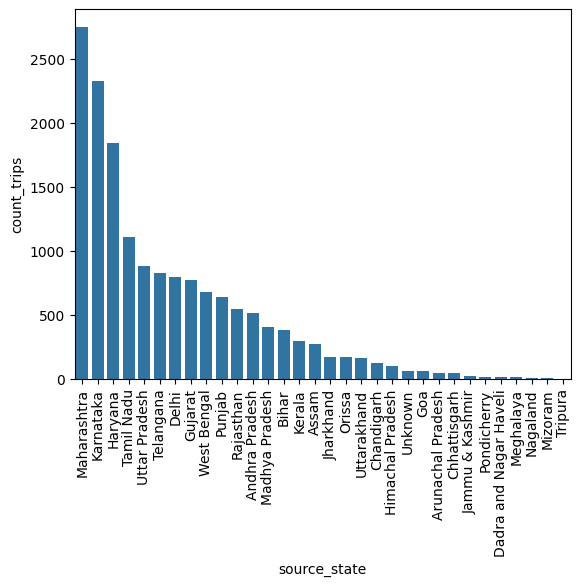

In [94]:
sns.barplot(data=orders_from_df,x='source_state',y='count_trips')
plt.xticks(rotation=90)
plt.show()

Destination of orders

In [95]:
orders_to_df=df.groupby('destination_state').agg(count_trips=('trip_uuid','nunique')).reset_index()
orders_to_df=orders_to_df.sort_values(by='count_trips', ascending=False)
orders_to_df

,destination_state,count_trips
18,Maharashtra,2637
15,Karnataka,2426
11,Haryana,1803
26,Tamil Nadu,1097
30,Uttar Pradesh,897
27,Telangana,856
10,Gujarat,791
32,West Bengal,713
24,Punjab,693
8,Delhi,675


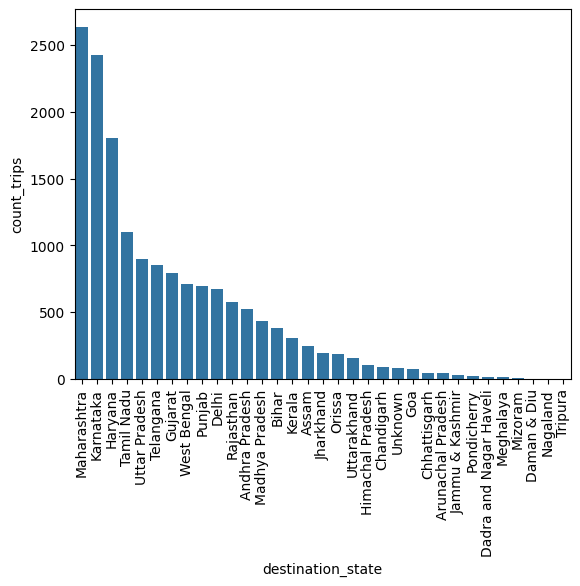

In [96]:
sns.barplot(data=orders_to_df,x='destination_state',y='count_trips')
plt.xticks(rotation=90)
plt.show()

**Most Busiest Corridor**

In [97]:
df['corridor']=df.apply(lambda x:"#".join([x['source_center'],x['destination_center']]), axis=1)
df

,data,trip_creation_time,route_schedule_uuid,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,od_start_time,...,source_state,destination_state,trip_actual_time_sum,trip_osrm_time_sum,trip_osrm_distance_sum,trip_segment_actual_time_sum,trip_segment_osrm_time_sum,trip_segment_osrm_distance_sum,trip_total_time_in_hrs,corridor
0,training,2018-09-12 00:00:16.535741,thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...,FTL,trip-153671041653548748,IND209304AAA,Kanpur_Central_H_6 (Uttar Pradesh),IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),2018-09-12 16:39:46.858469,...,Uttar Pradesh,Haryana,1562.0,717.0,991.3523,1548.0,1008.0,1320.4733,37.668497,IND209304AAA#IND000000ACB
1,training,2018-09-12 00:00:16.535741,thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...,FTL,trip-153671041653548748,IND209304AAA,Kanpur_Central_H_6 (Uttar Pradesh),IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),2018-09-12 16:39:46.858469,...,Uttar Pradesh,Haryana,1562.0,717.0,991.3523,1548.0,1008.0,1320.4733,37.668497,IND209304AAA#IND000000ACB
2,training,2018-09-12 00:00:16.535741,thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...,FTL,trip-153671041653548748,IND209304AAA,Kanpur_Central_H_6 (Uttar Pradesh),IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),2018-09-12 16:39:46.858469,...,Uttar Pradesh,Haryana,1562.0,717.0,991.3523,1548.0,1008.0,1320.4733,37.668497,IND209304AAA#IND000000ACB
3,training,2018-09-12 00:00:16.535741,thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...,FTL,trip-153671041653548748,IND209304AAA,Kanpur_Central_H_6 (Uttar Pradesh),IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),2018-09-12 16:39:46.858469,...,Uttar Pradesh,Haryana,1562.0,717.0,991.3523,1548.0,1008.0,1320.4733,37.668497,IND209304AAA#IND000000ACB
4,training,2018-09-12 00:00:16.535741,thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...,FTL,trip-153671041653548748,IND209304AAA,Kanpur_Central_H_6 (Uttar Pradesh),IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),2018-09-12 16:39:46.858469,...,Uttar Pradesh,Haryana,1562.0,717.0,991.3523,1548.0,1008.0,1320.4733,37.668497,IND209304AAA#IND000000ACB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144862,test,2018-10-03 23:59:14.390954,thanos::sroute:c5f2ba2c-8486-4940-8af6-d1d2a6a...,Carting,trip-153861115439069069,IND628801AAA,Eral_Busstand_D (Tamil Nadu),IND628204AAA,Tirchchndr_Shnmgprm_D (Tamil Nadu),2018-10-04 01:44:53.808000,...,Tamil Nadu,Tamil Nadu,264.0,179.0,171.1103,258.0,221.0,223.5324,5.808548,IND628801AAA#IND628204AAA
144863,test,2018-10-03 23:59:42.701692,thanos::sroute:412fea14-6d1f-4222-8a5f-a517042...,FTL,trip-153861118270144424,IND583119AAA,Sandur_WrdN1DPP_D (Karnataka),IND583101AAA,Bellary_Dc (Karnataka),2018-10-04 03:58:40.726547,...,Karnataka,Karnataka,275.0,68.0,80.5787,274.0,67.0,80.5787,5.906793,IND583119AAA#IND583101AAA
144864,test,2018-10-03 23:59:42.701692,thanos::sroute:412fea14-6d1f-4222-8a5f-a517042...,FTL,trip-153861118270144424,IND583119AAA,Sandur_WrdN1DPP_D (Karnataka),IND583101AAA,Bellary_Dc (Karnataka),2018-10-04 03:58:40.726547,...,Karnataka,Karnataka,275.0,68.0,80.5787,274.0,67.0,80.5787,5.906793,IND583119AAA#IND583101AAA
144865,test,2018-10-03 23:59:42.701692,thanos::sroute:412fea14-6d1f-4222-8a5f-a517042...,FTL,trip-153861118270144424,IND583201AAA,Hospet (Karnataka),IND583119AAA,Sandur_WrdN1DPP_D (Karnataka),2018-10-04 02:51:44.712656,...,Karnataka,Karnataka,275.0,68.0,80.5787,274.0,67.0,80.5787,5.906793,IND583201AAA#IND583119AAA


In [98]:
corridor_total_trips=df.groupby(['trip_uuid','corridor']).nth(-1).groupby(['corridor']).agg(total_trips=('trip_uuid','nunique')).reset_index()
corridor_total_trips

,corridor,total_trips
0,IND000000AAL#IND411033AAA,18
1,IND000000AAQ#IND700028AAB,2
2,IND000000AAS#IND783370AAC,9
3,IND000000AAZ#IND444203AAA,1
4,IND000000AAZ#IND444303AAA,1
...,...,...
2778,IND854334AAA#IND852118AAA,7
2779,IND854334AAA#IND854335AAA,2
2780,IND854335AAA#IND852111AAA,17
2781,IND854335AAA#IND852118A1B,1


In [99]:
corridor_actual_time_mean_df=df.groupby(['trip_uuid','corridor']).nth(-1).groupby(['corridor']).agg(corridor_actual_time_mean=('segment_actual_time_cumsum','mean')).reset_index()
corridor_actual_time_mean_df

,corridor,corridor_actual_time_mean
0,IND000000AAL#IND411033AAA,87.388889
1,IND000000AAQ#IND700028AAB,84.500000
2,IND000000AAS#IND783370AAC,61.000000
3,IND000000AAZ#IND444203AAA,287.000000
4,IND000000AAZ#IND444303AAA,159.000000
...,...,...
2778,IND854334AAA#IND852118AAA,28.285714
2779,IND854334AAA#IND854335AAA,40.500000
2780,IND854335AAA#IND852111AAA,39.470588
2781,IND854335AAA#IND852118A1B,40.000000


In [100]:
corridor_osrm_time_mean_df=df.groupby(['trip_uuid','corridor']).nth(-1).groupby(['corridor']).agg(corridor_dsrm_time_mean=('segment_osrm_time_cumsum','mean')).reset_index()
corridor_osrm_time_mean_df

,corridor,corridor_dsrm_time_mean
0,IND000000AAL#IND411033AAA,29.777778
1,IND000000AAQ#IND700028AAB,14.000000
2,IND000000AAS#IND783370AAC,29.000000
3,IND000000AAZ#IND444203AAA,77.000000
4,IND000000AAZ#IND444303AAA,68.000000
...,...,...
2778,IND854334AAA#IND852118AAA,21.428571
2779,IND854334AAA#IND854335AAA,29.500000
2780,IND854335AAA#IND852111AAA,19.294118
2781,IND854335AAA#IND852118A1B,18.000000


In [101]:
corridor_osrm_distance_mean_df=df.groupby(['trip_uuid','corridor']).nth(-1).groupby(['corridor']).agg(corridor_osrm_distance_mean=('segment_osrm_distance_cumsum','mean')).reset_index()
corridor_osrm_distance_mean_df

,corridor,corridor_osrm_distance_mean
0,IND000000AAL#IND411033AAA,28.885561
1,IND000000AAQ#IND700028AAB,13.900700
2,IND000000AAS#IND783370AAC,41.461622
3,IND000000AAZ#IND444203AAA,109.306700
4,IND000000AAZ#IND444303AAA,93.706900
...,...,...
2778,IND854334AAA#IND852118AAA,23.881371
2779,IND854334AAA#IND854335AAA,36.500750
2780,IND854335AAA#IND852111AAA,27.870394
2781,IND854335AAA#IND852118A1B,26.726200


In [102]:
corridor_aggregated_df=pd.concat(
    objs=(
            iDF.set_index('corridor') for iDF in (corridor_total_trips,
                                                  corridor_actual_time_mean_df,
                                                  corridor_osrm_distance_mean_df,
                                                   corridor_osrm_time_mean_df
                                                 )
         ),
    axis=1,
    join='inner'
).reset_index()
corridor_aggregated_df

,corridor,total_trips,corridor_actual_time_mean,corridor_osrm_distance_mean,corridor_dsrm_time_mean
0,IND000000AAL#IND411033AAA,18,87.388889,28.885561,29.777778
1,IND000000AAQ#IND700028AAB,2,84.500000,13.900700,14.000000
2,IND000000AAS#IND783370AAC,9,61.000000,41.461622,29.000000
3,IND000000AAZ#IND444203AAA,1,287.000000,109.306700,77.000000
4,IND000000AAZ#IND444303AAA,1,159.000000,93.706900,68.000000
...,...,...,...,...,...
2778,IND854334AAA#IND852118AAA,7,28.285714,23.881371,21.428571
2779,IND854334AAA#IND854335AAA,2,40.500000,36.500750,29.500000
2780,IND854335AAA#IND852111AAA,17,39.470588,27.870394,19.294118
2781,IND854335AAA#IND852118A1B,1,40.000000,26.726200,18.000000


**Busiest Corridor By Trips**

In [103]:
top_20Trips_corridor_df=corridor_aggregated_df[['corridor','total_trips']].sort_values(by='total_trips', ascending=False)[:20]
top_20Trips_corridor_df

,corridor,total_trips
1775,IND562132AAA#IND560300AAA,151
1774,IND562132AAA#IND560099AAB,127
1719,IND560099AAB#IND560300AAA,121
1735,IND560300AAA#IND562132AAA,108
1080,IND411033AAA#IND421302AAG,107
1152,IND421302AAG#IND400072AAB,105
1720,IND560099AAB#IND562132AAA,102
68,IND000000ACT#IND000000ACB,100
1010,IND400072AAD#IND421302AAG,99
38,IND000000ACB#IND131028AAB,92


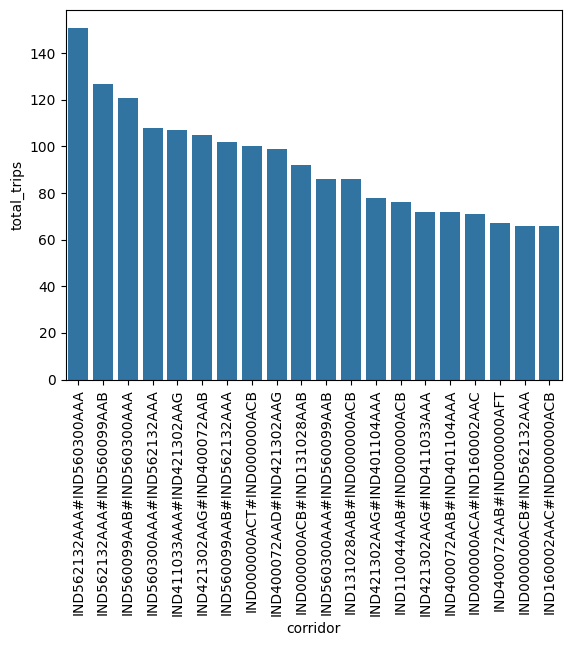

In [104]:
sns.barplot(data=top_20Trips_corridor_df,x='corridor',y='total_trips')
plt.xticks(rotation=90)
plt.show()

**Busiest corridor Actual time**

In [105]:
top_20trip_time_corridor_df=corridor_aggregated_df[['corridor','corridor_actual_time_mean']].sort_values(by='corridor_actual_time_mean', ascending=False)[:20]
top_20trip_time_corridor_df

,corridor,corridor_actual_time_mean
356,IND160002AAC#IND562132AAA,3751.000000
2511,IND781018AAB#IND110037AAM,3341.764706
119,IND110037AAM#IND781018AAB,3281.000000
2276,IND712311AAA#IND421302AAG,3141.200000
60,IND000000ACB#IND600056AAB,3090.857143
1786,IND562132AAA#IND712311AAA,3010.333333
1169,IND421302AAG#IND712311AAA,2902.000000
355,IND160002AAC#IND421302AAG,2867.000000
59,IND000000ACB#IND562132AAA,2864.136364
1753,IND562132AAA#IND000000ACB,2766.454545


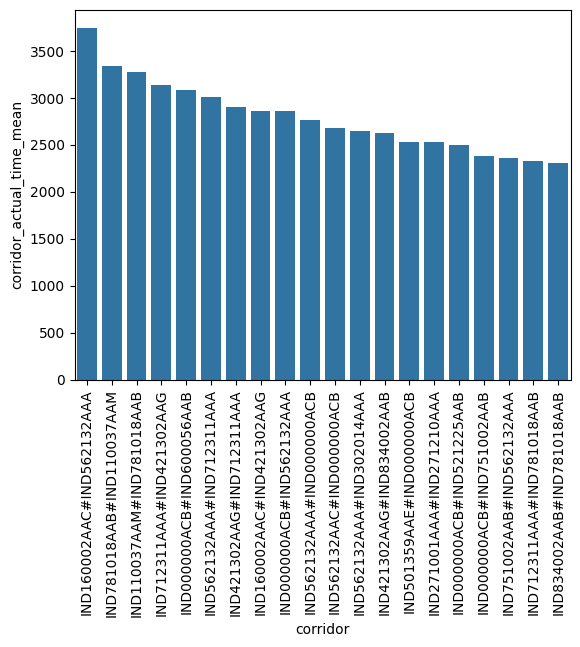

In [106]:
sns.barplot(data=top_20trip_time_corridor_df,x='corridor',y='corridor_actual_time_mean')
plt.xticks(rotation=90)
plt.show()


In [107]:
corridor_aggregated_df[['corridor_actual_time_mean','corridor_osrm_distance_mean','corridor_dsrm_time_mean','total_trips']].corr()

,corridor_actual_time_mean,corridor_osrm_distance_mean,corridor_dsrm_time_mean,total_trips
corridor_actual_time_mean,1.000000,0.925839,0.920682,0.019402
corridor_osrm_distance_mean,0.925839,1.000000,0.995558,0.051330
corridor_dsrm_time_mean,0.920682,0.995558,1.000000,0.052003
total_trips,0.019402,0.051330,0.052003,1.000000


**Busiest Corridor by Distance**

In [108]:
top_20trip_dist_corridor_df=corridor_aggregated_df[['corridor','corridor_osrm_distance_mean']].sort_values(by='corridor_osrm_distance_mean', ascending=False)[:20]
top_20trip_dist_corridor_df

,corridor,corridor_osrm_distance_mean
1169,IND421302AAG#IND712311AAA,2584.622933
356,IND160002AAC#IND562132AAA,2500.214500
2276,IND712311AAA#IND421302AAG,2363.329580
60,IND000000ACB#IND600056AAB,2361.555264
1753,IND562132AAA#IND000000ACB,2312.589602
1788,IND562132AAC#IND000000ACB,2307.137400
2511,IND781018AAB#IND110037AAM,2300.517159
59,IND000000ACB#IND562132AAA,2288.400620
119,IND110037AAM#IND781018AAB,2181.460700
62,IND000000ACB#IND751002AAB,2134.451707


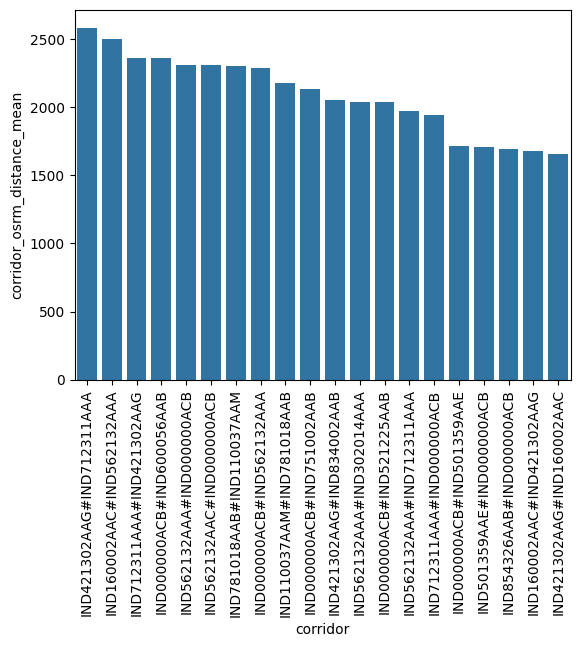

In [109]:
sns.barplot(data=top_20trip_dist_corridor_df,x='corridor',y='corridor_osrm_distance_mean')
plt.xticks(rotation=90)
plt.show()

**Business Recommendations**

Maharashtra, Karnataka, Tamil Nadu, Utter Pradesh, Telangana and Gujarat States has most delivery trips are done.By this we can consider this to be most Bussiest corridor are in these states.

Focus should be on identifying best corridors to move packages very quickly,  potential reasons for difference in actual delivery time and osrm delivery time value. Bridginf this gap can positivly effect the outcomes.

Focus should be on hops in between the trips,if Actual delivery time is higher than osrm time , which are causing delays,and if delays are related to processing or logistic that should be quickly fixed.

Focus should be on identifying best route to move packages quickly, if Issue is not related to delivery and logistic process.